## Modelo LUR

Fusion inicial:
                    Estación                             Coordenadas  \
0  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
1  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
2  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
3  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
4  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   

                   date    PM25  Humidity  Temperature  
0  2025-03-01T01:00:00Z  17.745    77.936        18.17  
1  2025-03-01T02:00:00Z  18.760    78.760        18.00  
2  2025-03-01T03:00:00Z  13.200    80.000        18.00  
3  2025-03-01T04:00:00Z     NaN       NaN          NaN  
4  2025-03-01T05:00:00Z  13.000    80.000        18.00  
Tras separar coordenadas:
                    Estación                             Coordenadas  \
0  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
1  SAM_IE_BuenosAires_306e73  4.5652591

/tmp/ipykernel_3339/3054377111.py:119: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  hotspots.plot(ax=ax, color="crimson", markersize=100, label="Hotspots High–High")


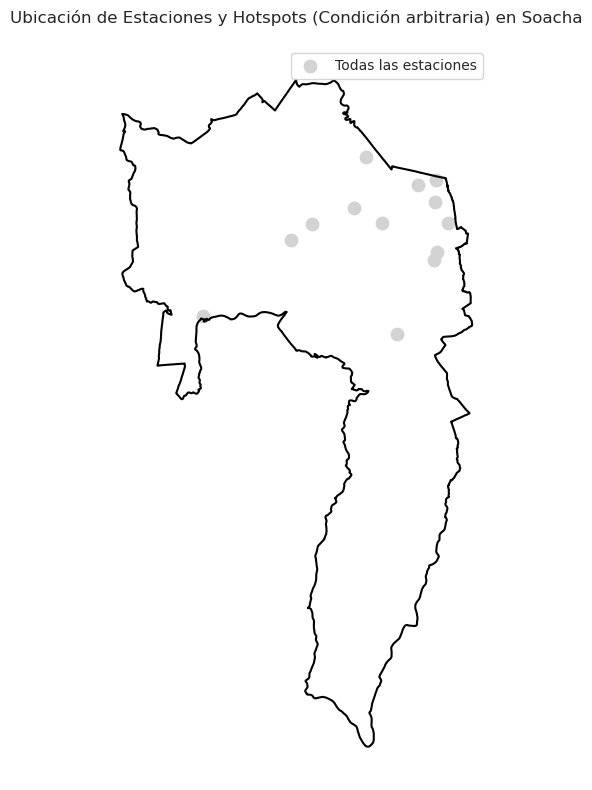

Moran’s I Global para PM2.5: -0.1987
p-valor (normal) Global: 0.3567


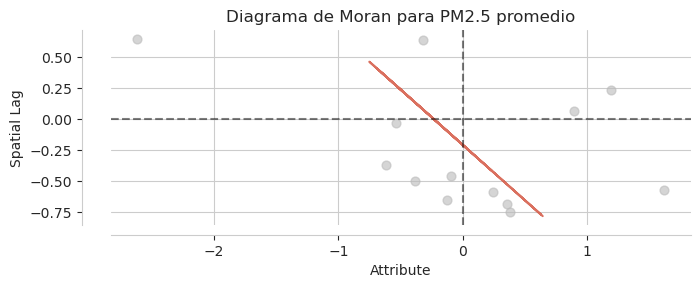

                          Estación  PM25_mean  lisa_q  lisa_type  lisa_p
0        SAM_IE_BuenosAires_306e73  12.188792       3    Low–Low   0.429
1             SAM_IE_Cazuca_7f4c00  20.338745       1  High–High   0.227
2             SAM_IE_Chiloe_6eeafa  14.129366       3    Low–Low   0.099
3        SAM_IE_ElCharquito_3075d1  18.937467       1  High–High   0.413
4         SAM_IE_ElProgreso_1c4cc9  22.345122       4   High–Low   0.184
5            SAM_IE_Fusunga_4d410c  14.268714       3    Low–Low   0.201
6   SAM_IE_GeneralSantander_edee42  16.486133       4   High–Low   0.078
7         SAM_IE_LaDespensa_7c0276  15.863100       4   High–Low   0.140
8           SAM_IE_LeonXIII_fb3f2c  11.790557       3    Low–Low   0.211
9    SAM_IE_LuisCarlosGalan_e38027  13.215638       2   Low–High   0.082
10    SAM_IE_NuevoCompartir_fc04d7  12.914084       3    Low–Low   0.159
11     SAM_IE_PazyEsperanza_f36757  16.399616       4   High–Low   0.106
12          SAM_IE_Ricaurte_16e48f   2.395333      

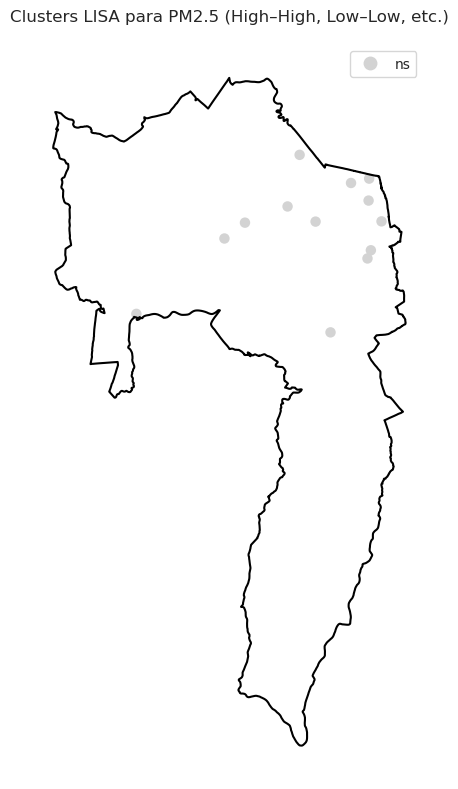


Número de estaciones en High–High (hotspots) significativos: 0
Empty DataFrame
Columns: [Estación, PM25_mean, lisa_p]
Index: []
                            OLS Regression Results                            
Dep. Variable:              PM25_mean   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     5.259
Date:                Mon, 23 Jun 2025   Prob (F-statistic):             0.0364
Time:                        01:44:11   Log-Likelihood:                -24.897
No. Observations:                  11   AIC:                             59.79
Df Residuals:                       6   BIC:                             61.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>

/opt/miniconda/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [7]:
# =============================================================================
# 0. Importar Librerías
# =============================================================================
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Para manejo de rutas
from pathlib import Path
from shapely.geometry import Point

# Para análisis de series temporales (si se requiere)
import statsmodels.tsa.stattools as ts
from scipy.stats import pearsonr

# Para análisis espacial
import libpysal as ps
from esda import Moran, Moran_Local, Moran_BV
from splot.esda import moran_scatterplot, lisa_cluster

# Para regresión espacial (modelo LUR)
import statsmodels.formula.api as smf

# =============================================================================
# 1. Cargar datos y prepararlos
# =============================================================================
# Rutas a los archivos
root_folder = "/notebooks/"
MON_path = root_folder + "data_MAR_1.csv"              # Datos de monitoreo de sensores
excel_path = root_folder + "Coordenadas_Instituciones.xlsx"   # Coordenadas de instituciones (estaciones)
SHAPE_MUN = root_folder + "municipios_colombia.shp"         # Shapefile de municipios
SHAPE_REDVIAL = root_folder + "RedVial.shp"                 # Shapefile de red vial
SHAPE_SUELO = root_folder + "Usos_Suelo_Urbano_POT._Municipio_de_Soacha._2000_(capa).shp"  # Capa de Uso del suelo

# Cargar shapefiles de límite municipal, red vial y capa de suelo
gdf_mun = gpd.read_file(SHAPE_MUN)
gdf_road = gpd.read_file(SHAPE_REDVIAL)
gdf_suelo = gpd.read_file(SHAPE_SUELO)

# Cargar coordenadas y datos de monitoreo
df_coord = pd.read_excel(excel_path, sheet_name="Hoja1")
df_moni = pd.read_csv(MON_path)

# Asegurarse de que la columna de estación tenga el nombre correcto
df_moni.rename(columns={"station": "Estación"}, inplace=True)

# Fusionar las tablas por la columna “Estación”
datos_combinados = pd.merge(df_coord, df_moni, on="Estación", how="inner")
print("Fusion inicial:")
print(datos_combinados.head())

# Separar la columna 'Coordenadas' en 'Latitud' y 'Longitud'
datos_combinados[['Latitud', 'Longitud']] = datos_combinados['Coordenadas'].str.split(',', expand=True)
# Quitar espacios en blanco y convertir a float
datos_combinados['Latitud'] = datos_combinados['Latitud'].astype(float)
datos_combinados['Longitud'] = datos_combinados['Longitud'].astype(float)

print("Tras separar coordenadas:")
print(datos_combinados.head())
print("Columnas disponibles:", list(datos_combinados.columns))

# =============================================================================
# 2. Generar el GeoDataFrame de Estaciones (resumen por estación)
# =============================================================================
# Supongamos que df_moni tiene lecturas diarias y ya se han agregado por estación.
# Aquí usamos station_summary que ya calculó estadísticas (por ejemplo, PM2.5, Humedad, Temperatura).
station_summary = df_moni.groupby("Estación").agg({
    "PM25": ["mean", "std", "min", "max"],
    "Humidity": ["mean", "std", "min", "max"],
    "Temperature": ["mean", "std", "min", "max"]
}).reset_index()
# Aplanar nombres de columnas del MultiIndex
station_summary.columns = [
    "Estación",
    "PM25_mean", "PM25_std", "PM25_min", "PM25_max",
    "Humidity_mean", "Humidity_std", "Humidity_min", "Humidity_max",
    "Temperature_mean", "Temperature_std", "Temperature_min", "Temperature_max"
]

print("\nResumen estadístico por estación:")
print(station_summary.head())

# Extraer las coordenadas únicas (por estación) desde datos_combinados
coord_estaciones = datos_combinados[["Estación", "Latitud", "Longitud"]].drop_duplicates()
# Fusionar con el resumen por estación
gdf_est = station_summary.merge(coord_estaciones, on="Estación")
# Crear la geometría: cada estación se representa como un punto
geometry = [Point(xy) for xy in zip(gdf_est["Longitud"], gdf_est["Latitud"])]
gdf_est = gpd.GeoDataFrame(gdf_est, geometry=geometry, crs="EPSG:4326")

# Proyectar al CRS que desees; en este caso a EPSG:9377 (MAGNA-SIRGAS, apropiado para datos en Bogotá/Soacha)
gdf_est = gdf_est.to_crs(epsg=9377)

# También, proyectar los shapefiles de Soacha (municipios), red vial y suelo a EPSG:9377:
gdf_mun = gdf_mun.to_crs(epsg=9377)
gdf_road = gdf_road.to_crs(epsg=9377)
gdf_suelo = gdf_suelo.to_crs(epsg=9377)

# =============================================================================
# 3. Visualización de estaciones sobre el mapa del municipio de Soacha
# =============================================================================
# Filtrar el municipio de Soacha (ajusta el nombre según tu shapefile)
gdf_soacha = gdf_mun[gdf_mun["MPIO_CNMBR"].str.upper() == "SOACHA"]

fig, ax = plt.subplots(figsize=(10, 8))
# Dibujar el contorno del municipio (límites)
gdf_soacha.boundary.plot(ax=ax, color="black")
# Graficar todas las estaciones en gris claro
gdf_est.plot(ax=ax, color="lightgray", markersize=80, label="Todas las estaciones")
# Destacar las estaciones hotspots (más adelante se definirán)
# Por ahora, asumiremos que la variable 'hotspots' se ha calculado.
# Si aún no lo hacemos, se puede crear una máscara vacía o repetir gdf_est (para ilustración)
# En este ejemplo, definimos hotspots como estaciones con PM2.5_mean superior a un umbral arbitrario (por ejemplo, > 25)
hotspots = gdf_est[gdf_est["PM25_mean"] > 25]  # Ejemplo; ajustar según tus datos
hotspots.plot(ax=ax, color="crimson", markersize=100, label="Hotspots High–High")

# Etiquetar las estaciones hotspots
for x, y, label in zip(hotspots.geometry.x, hotspots.geometry.y, hotspots["Estación"]):
    ax.text(x, y, label, fontsize=9, ha="right")

ax.set_title("Ubicación de Estaciones y Hotspots (Condición arbitraria) en Soacha")
ax.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

# =============================================================================
# 4. Análisis espacial: Cálculo del índice de Moran Global y Local (LISA)
# =============================================================================
# Crear matriz de pesos (KNN, k=4) para las estaciones
coords = np.array(list(zip(gdf_est.geometry.x, gdf_est.geometry.y)))
knn_w = ps.weights.KNN.from_array(coords, k=4)
knn_w.transform = "R"  # Normalizamos fila a fila

# Calcular el índice de Moran Global para PM2.5
moran_pm = Moran(gdf_est["PM25_mean"], knn_w)
print(f"Moran’s I Global para PM2.5: {moran_pm.I:.4f}")
print(f"p-valor (normal) Global: {moran_pm.p_norm:.4f}")

# Diagrama de dispersión de Moran
fig, ax = moran_scatterplot(moran_pm, aspect_equal=True)
ax.set_title("Diagrama de Moran para PM2.5 promedio")
plt.tight_layout()
plt.show()

# Calcular el índice Local de Moran (LISA)
lisa = Moran_Local(gdf_est["PM25_mean"], knn_w)

# Agregar resultados LISA al GeoDataFrame
gdf_est["lisa_q"] = lisa.q  # Determina los cuadrantes: 1=High–High, 2=Low–High, 3=Low–Low, 4=High–Low
gdf_est["lisa_p"] = lisa.p_sim  # p-value local

# Crear una columna categórica interpretativa
gdf_est["lisa_type"] = gdf_est["lisa_q"].map({
    1: "High–High",
    2: "Low–High",
    3: "Low–Low",
    4: "High–Low"
})
print(gdf_est[["Estación", "PM25_mean", "lisa_q", "lisa_type", "lisa_p"]])

# Visualizar el mapa LISA
fig, ax = plt.subplots(figsize=(10, 8))
lisa_cluster(lisa, gdf_est, p=0.05, ax=ax, legend=True)
gdf_soacha.boundary.plot(ax=ax, color="black")
ax.set_title("Clusters LISA para PM2.5 (High–High, Low–Low, etc.)")
plt.tight_layout()
plt.show()

# Contar el número de Hotspots (High–High) significativos (p < 0.05)
hotspots = gdf_est[(gdf_est["lisa_q"] == 1) & (gdf_est["lisa_p"] < 0.05)]
print(f"\nNúmero de estaciones en High–High (hotspots) significativos: {len(hotspots)}")
print(hotspots[["Estación", "PM25_mean", "lisa_p"]])

# =============================================================================
# 5. Construcción del modelo LUR
# =============================================================================
# Para el modelo LUR usaremos variables de la estación:
# - PM2.5 promedio (variable dependiente)
# - Temperature_mean y Humidity_mean (variables explicativas)
# Además, incorporamos indicadores derivados de capas:
# (a) Información de uso del suelo: se hace un spatial join con gdf_suelo.
gdf_est = gpd.sjoin(gdf_est, gdf_suelo[["USO_SUELO", "geometry"]], how="left", predicate="within")

# (b) Distancia a la red vial: calcular la distancia a la carretera más cercana.
# Esta es una forma sencilla de obtener un predictor derivado de la red vial.
gdf_est["dist_road"] = gdf_est.geometry.apply(lambda geom: gdf_road.distance(geom).min())

# Crear un DataFrame para modelo LUR con las variables necesarias.
df_model = gdf_est[["PM25_mean", "Temperature_mean", "Humidity_mean", "USO_SUELO", "dist_road"]].copy()
# Convertir uso_suelo a variable categórica, si aún no lo es.
df_model["uso_suelo"] = df_model["USO_SUELO"].astype("category")

# Ajustar el modelo LUR (OLS)
model = smf.ols("PM25_mean ~ Temperature_mean + Humidity_mean + dist_road + C(USO_SUELO)", data=df_model).fit()
print(model.summary())

# Evaluar los residuos del modelo con Moran’s I para ver si quedan patrones espaciales significativos.
df_model["resid"] = model.resid
# Recalcular pesos espaciales sobre las mismas coordenadas
coords = np.array(list(zip(gdf_est.geometry.x, gdf_est.geometry.y)))
knn_w = ps.weights.KNN.from_array(coords, k=4)
knn_w.transform = "R"

moran_resid = Moran(df_model["resid"], knn_w)
print(f"\nMoran’s I para los residuos del modelo: {moran_resid.I:.4f}")
print(f"p-valor (residuos): {moran_resid.p_norm:.4f}")

# =============================================================================
# Interpretación final
# =============================================================================
# Si el modelo LUR presenta:
# - Buen ajuste en el summary (coeficientes significativos, R2 adecuado).
# - Los residuos no muestran autocorrelación espacial significativa (Moran p-value >= 0.05),
# entonces puedes justificar un LUR "puro".
# En cambio, si quedara autocorrelación espacial en los residuos, se debería considerar 
# incorporar estructuras espaciales adicionales (por ejemplo, un modelo de Spatial Lag o GWR).

Se resumen dos aspectos importantes en el análisis de un modelo de regresión espacial y en la evaluación de sus residuos:

1. **Notas del Modelo de Regresión:**  
   - **Errores estándar y especificación:**  
     La primera nota indica que los errores estándar se calculan bajo el supuesto de que la matriz de covarianza de los errores está correctamente especificada. Es decir, se asume que la forma en que se modelan las variaciones y correlaciones en los errores es la adecuada para los datos. Si esta especificación no es correcta, las estimaciones de los errores estándar y, por tanto, los intervalos de confianza y pruebas de hipótesis podrían ser engañosos.
     
   - **Número de condición elevado:**  
     La segunda nota muestra que el número de condición es muy grande (7.58e+04). Este parámetro es una medida de la estabilidad numérica del sistema y, en el contexto de la regresión, es particularmente útil para detectar **multicolinealidad** (es decir, cuando varias variables independientes están fuertemente correlacionadas entre sí). Un número de condición elevado sugiere que algunas de las variables predictoras comparten información redundante o que pueden existir otros problemas numéricos, lo que dificulta la interpretación fiable de los coeficientes del modelo.

2. **Resultados del Análisis Espacial de los Residuos (Moran’s I):**  
   - **Moran’s I y p-valor para los residuos:**  
     Posteriormente se indica que el valor de Moran’s I calculado para los residuos del modelo es `nan` (Not a Number), al igual que su p-valor. Moran’s I es una medida de autocorrelación espacial que intenta identificar si los residuos del modelo presentan patrones de agrupación espacial (por ejemplo, si los errores de predicción tienden a agruparse geográficamente).  
     
     Que ambos resultados sean `nan` sugiere que la prueba no pudo calcularse correctamente; esto puede deberse a varias causas, entre ellas:
     - **Número insuficiente de observaciones:** En este caso, el análisis se realiza con solo 11 estaciones, lo que es muy bajo para obtener resultados confiables de Moran’s I.  
     - **Problemas en la estructuración de los datos o en la matriz de pesos espaciales:** Si la configuraciones para definir la vecindad espacial no son adecuadas, es posible que la prueba no se ejecute correctamente.
     
En el contexto de la página adyacente, donde se muestra el flujo de un análisis espacial y de regresión (incluyendo la generación de un modelo LUR, la generación de resumen estadístico por estación y la construcción de clústeres mediante análisis LISA), este texto sirve para alertar al analista de posibles limitaciones en la robustez del modelo y de las pruebas estadísticas. La presencia de un número de condición elevado y de resultados `nan` en el análisis de autocorrelación espacial de los residuos indica que:
  
- **Multicolinealidad o problemas numéricos** pueden estar afectando la estabilidad y la interpretabilidad del modelo de regresión.
- **La baja cantidad de datos (n=11)** es insuficiente para obtener resultados confiables en las pruebas de autocorrelación espacial, lo que obliga a considerar la necesidad de contar con más observaciones o de ajustar la metodología (por ejemplo, modificando la definición de la vecindad espacial).

En resumen, el modelo sugiere precaución al interpretar los coeficientes y las inferencias estadísticas, y alerta sobre la necesidad de mejorar la robustez del análisis espacial, ya sea mediante la recopilación de más datos, la revisión de la especificación del modelo o el ajuste de los parámetros en la construcción de la matriz de pesos espaciales.

# Para que un clúster del tipo High–High (alto-alto) sea considerado estadísticamente significativo en el análisis LISA, debe cumplir con:
✅ Dos criterios:
- Valor LISA (lisa_q) igual a 1, que indica un agrupamiento de estaciones con valores de PM2.5 altos rodeados por vecinos también altos.
- Un valor de p (lisa_p) menor a 0.05, que indica que ese patrón no ocurrió por azar.

# 🔍 En los datos:
Estación                     lisa_type   lisa_p
SAM_IE_Cazuca_7f4c00        High–High    0.230 ❌
SAM_IE_ElCharquito_3075d1   High–High    0.406 ❌


Ambas estaciones están clasificadas como High–High, pero sus valores p > 0.05, así que no son estadísticamente significativas. En otras palabras: aunque parecen estar en zonas con PM2.5 altos, el agrupamiento no es lo suficientemente fuerte o consistente para que el modelo LISA lo considere “confiable” desde una perspectiva estadística.

# 🧠 por  evaliuar
- Investigar por qué esos clústeres no son significativos: ¿falta densidad de estaciones? ¿demasiada variabilidad local?
- Probar con diferentes configuraciones de vecinos espaciales (k) o usar pesos por distancia para afinar el patrón.


In [5]:
print(gdf_est.head())

                    Estación  PM25_mean   PM25_std  PM25_min  PM25_max  \
0  SAM_IE_BuenosAires_306e73  12.188792   5.604355     2.183    28.914   
1       SAM_IE_Cazuca_7f4c00  20.338745   8.807108     2.117    49.150   
2       SAM_IE_Chiloe_6eeafa  14.129366   6.721416     2.033    35.133   
3  SAM_IE_ElCharquito_3075d1  18.937467   7.759388     2.359    41.517   
4   SAM_IE_ElProgreso_1c4cc9  22.345122  10.631144     2.900   105.317   

   Humidity_mean  Humidity_std  Humidity_min  Humidity_max  Temperature_mean  \
0      76.558277      7.849442        51.925        87.500         17.727686   
1      83.824922      9.028276        53.233        97.633         18.131486   
2      79.608109      8.154298        43.700        96.317         18.512361   
3      78.724593     10.087844        49.267        92.917         18.295353   
4      91.831392      9.033887        53.017       100.000         16.726869   

   ...  Temperature_max   Latitud   Longitud                         geome